# Import required libraries and preparation

In [1]:
%%capture
%pip install python-docx

In [34]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import docx
import spacy
from wordcloud import WordCloud
from textblob import TextBlob
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations
from collections import defaultdict
from sentence_transformers import SentenceTransformer

In [8]:
# Ensure nltk data is downloaded
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

# Load Spacy's English NER model
nlp = spacy.load("en_core_web_sm")

# Directory containing AI model response files (.docx)
DATA_DIR = "ai_responses"

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Preprocessing, Sentiment Analysis & NER

In [9]:
# Function to extract text from .docx file
def extract_text_from_docx(file_path):
    doc = docx.Document(file_path)
    full_text = []
    for para in doc.paragraphs:
        full_text.append(para.text)
    return "\n".join(full_text)

# Function to preprocess text: Tokenization and stopword removal
def preprocess_text(text):
    words = word_tokenize(text.lower())  # Convert to lowercase and tokenize
    words = [word for word in words if word.isalpha()]  # Remove punctuation
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return words

In [10]:
# Function to analyze sentiment
def analyze_sentiment(text):
    return TextBlob(text).sentiment.polarity  # -1 (negative) to +1 (positive)

# Named Entity Recognition (NER) to detect gender, ethnicity, political bias
def perform_ner(text):
    doc = nlp(text)
    entities = {"PERSON": [], "ORG": [], "GPE": [], "NORP": []}  # GPE (Locations), NORP (Nationalities, Political groups)
    for ent in doc.ents:
        if ent.label_ in entities:
            entities[ent.label_].append(ent.text)
    return entities

In [11]:
# Read all AI model responses from .docx files
responses = []
for filename in os.listdir(DATA_DIR):
    if filename.endswith(".docx"):
        model_name = filename.replace(".docx", "")
        file_path = os.path.join(DATA_DIR, filename)
        text = extract_text_from_docx(file_path)
        words = preprocess_text(text)
        sentiment = analyze_sentiment(text)
        responses.append({"Model": model_name, "Text": text, "Words": words, "Sentiment": sentiment})

In [12]:
# Read AI model responses from .docx files
responses = []
for filename in os.listdir(DATA_DIR):
    if filename.endswith(".docx"):
        model_name = filename.replace(".docx", "")
        file_path = os.path.join(DATA_DIR, filename)
        text = extract_text_from_docx(file_path)
        words = preprocess_text(text)
        sentiment = analyze_sentiment(text)
        ner_results = perform_ner(text)

        responses.append({
            "Model": model_name,
            "Text": text,
            "Total Words": len(words),
            "Sentiment": sentiment,
            "Persons Mentioned": ner_results["PERSON"],
            "Organizations Mentioned": ner_results["ORG"],
            "Countries/Places": ner_results["GPE"],
            "Nationalities/Political Groups": ner_results["NORP"]
        })

# Convert to DataFrame
df = pd.DataFrame(responses)

In [13]:
df

,Model,Text,Total Words,Sentiment,Persons Mentioned,Organizations Mentioned,Countries/Places,Nationalities/Political Groups
0,Gemini-2.0-Flash,"Determining the ""greatest"" scientists involves...",1653,0.096621,"[Albert Einstein, Einstein, Isaac Newton, Mari...","[Tesla, technologies[4][5, telescope[4][5, Arc...","[Newton, AI, AI, AI, AI, AI, AI, AI, AI, AI, U...","[Irish, Irish, Irish, Irishman, Tesla, Irish]"
1,Claude-3.7-Sonnet,The greatest scientists in history are typical...,2275,0.108879,"[Isaac Newton, lists[1][2, Albert Einstein, ti...","[Top-Ranked Scientists Throughout History, Nik...","[Newton, universe[2][4, AI, U.S., AI, AI, AI, ...","[autonomy[16, autonomy[16, Irish, Irish, Irish..."
2,Grok-2,The greatest scientists in history have left a...,2243,0.105505,"[Isaac Newton, Albert Einstein, Einstein, Eins...","[Nikola Tesla, the electric motor, BC, Archime...","[Newton, AI, AI, AI, AI, AI, AI, AI, AI, AI, A...","[Aristotelian, British, English, Irishman, Nat..."
3,GPT-4.5,The greatest scientists in history are typical...,2190,0.100605,"[Albert Einstein, Isaac Newton, Marie Curie, A...","[Recognition, Nikola Tesla, AC, Pioneer, the e...","[AI, development[5][8, AI, AI, AI, AI, AI, AI,...","[Canadians, Italians, Canadians, Canadian, Can..."


# Data Visualization

<ipython-input-14-8d37b0bf8990>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Sentiment", data=df, palette="coolwarm")


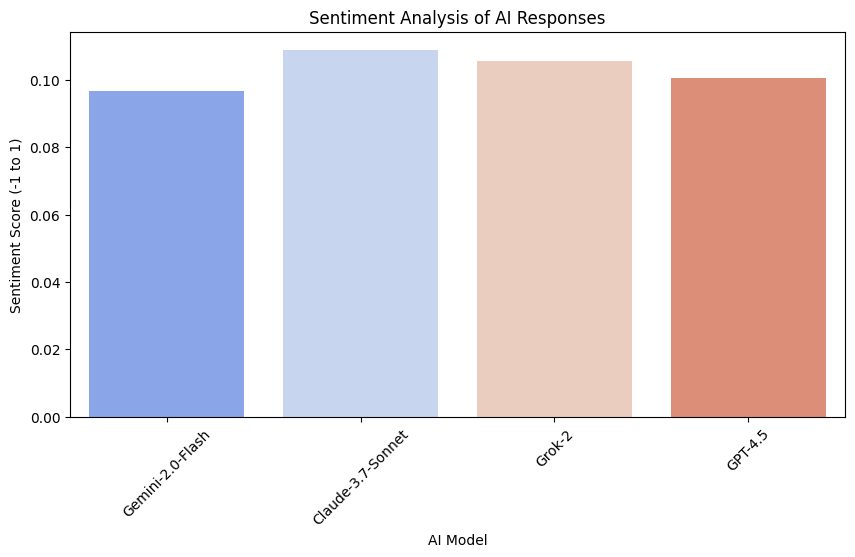

In [14]:
# Plot Sentiment Scores
plt.figure(figsize=(10, 5))
sns.barplot(x="Model", y="Sentiment", data=df, palette="coolwarm")
plt.title("Sentiment Analysis of AI Responses")
plt.xlabel("AI Model")
plt.ylabel("Sentiment Score (-1 to 1)")
plt.xticks(rotation=45)
plt.show()

<ipython-input-15-3a70d91db961>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Total Words", data=df, palette="viridis")


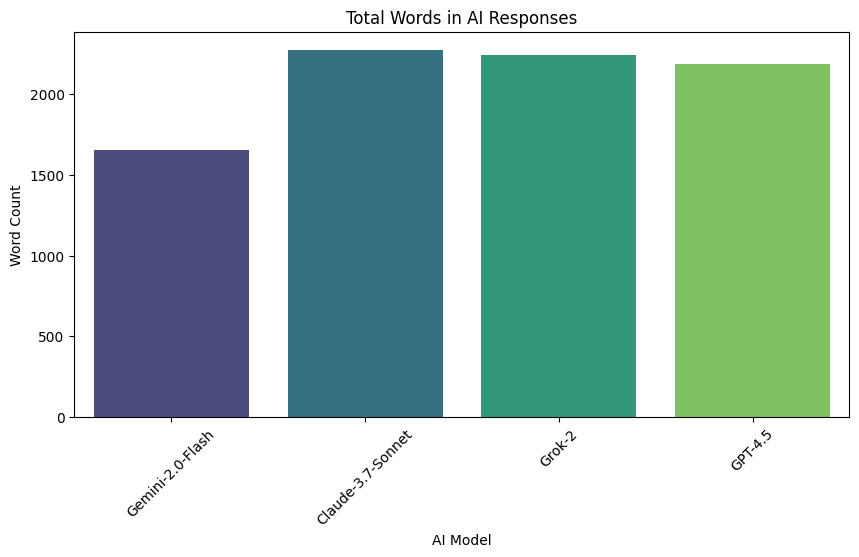

In [15]:
# Plot Total Words per AI Model
plt.figure(figsize=(10, 5))
sns.barplot(x="Model", y="Total Words", data=df, palette="viridis")
plt.title("Total Words in AI Responses")
plt.xlabel("AI Model")
plt.ylabel("Word Count")
plt.xticks(rotation=45)
plt.show()

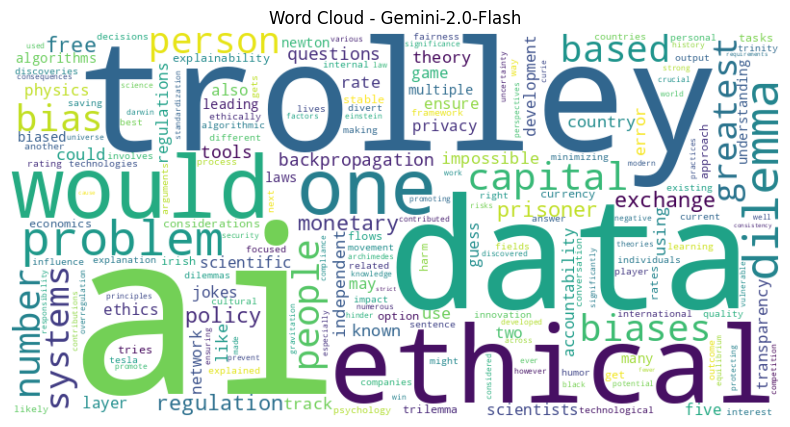

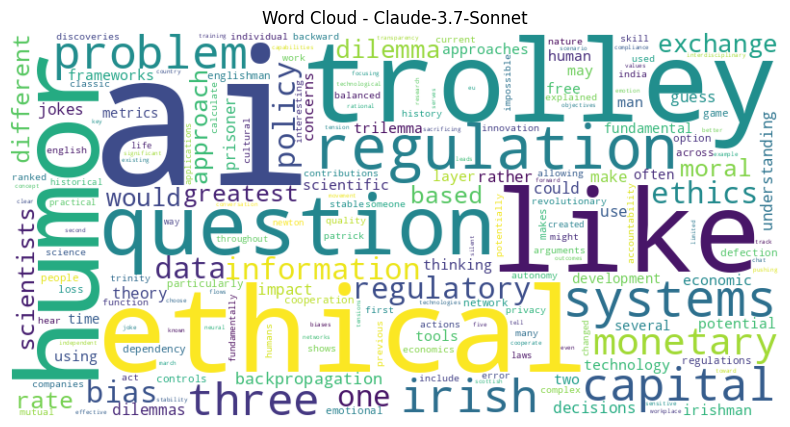

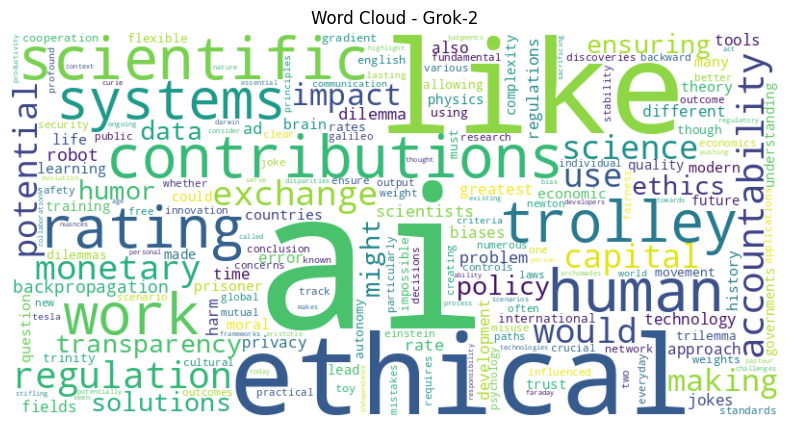

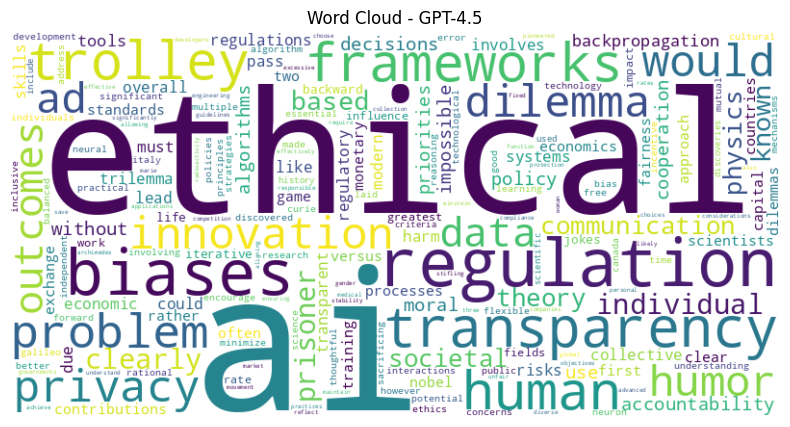

In [16]:
# Generate Word Clouds for each AI model
for index, row in df.iterrows():
    word_freq = Counter(preprocess_text(row["Text"]))
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_freq)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud - {row['Model']}")
    plt.show()

# Semantic Similarity - Cosine, Jaccard and BERT



In [33]:
# Load text from DOCX files
def load_text_from_docx(folder_path):
    texts = {}
    for file in os.listdir(folder_path):
        if file.endswith(".docx"):
            doc = docx.Document(os.path.join(folder_path, file))
            text = "\n".join([para.text for para in doc.paragraphs])
            texts[file] = text
    return texts

# Compute Cosine Similarity using TF-IDF
def compute_cosine_similarity(texts):
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(texts.values())
    cosine_sim_matrix = cosine_similarity(tfidf_matrix)

    # Create DataFrame for readability
    files = list(texts.keys())
    similarity_df = pd.DataFrame(cosine_sim_matrix, index=files, columns=files)
    return similarity_df

# Compute Jaccard Similarity
def compute_jaccard_similarity(texts):
    vectorizer = CountVectorizer(binary=True)  # Convert text to binary presence (bag of words)
    text_list = list(texts.values())
    binary_matrix = vectorizer.fit_transform(text_list).toarray()

    # Compute pairwise Jaccard similarity
    num_files = len(text_list)
    similarity_matrix = np.zeros((num_files, num_files))

    for i in range(num_files):
        for j in range(num_files):
            #if i != j:  # Avoid self-comparison
            similarity_matrix[i, j] = jaccard_score(binary_matrix[i], binary_matrix[j], average='macro')

    # Convert to DataFrame for better readability
    file_names = list(texts.keys())
    similarity_df = pd.DataFrame(similarity_matrix, index=file_names, columns=file_names)
    return similarity_df

# Main Execution
folder_path = "/content/ai_responses"
texts = load_text_from_docx(folder_path)

jaccard_sim_df = compute_jaccard_similarity(texts)
cosine_sim_df = compute_cosine_similarity(texts)
print("Cosine Similarity Between AI Model Responses:\n", cosine_sim_df)
print("-"*50)
print("\nJaccard Similarity Between AI Model Responses:\n", jaccard_sim_df)

Cosine Similarity Between AI Model Responses:
                         Gemini-2.0-Flash.docx  Claude-3.7-Sonnet.docx  \
Gemini-2.0-Flash.docx                1.000000                0.635583   
Claude-3.7-Sonnet.docx               0.635583                1.000000   
Grok-2.docx                          0.653633                0.643005   
GPT-4.5.docx                         0.572257                0.538515   

                        Grok-2.docx  GPT-4.5.docx  
Gemini-2.0-Flash.docx      0.653633      0.572257  
Claude-3.7-Sonnet.docx     0.643005      0.538515  
Grok-2.docx                1.000000      0.623377  
GPT-4.5.docx               0.623377      1.000000  
--------------------------------------------------

Jaccard Similarity Between AI Model Responses:
                         Gemini-2.0-Flash.docx  Claude-3.7-Sonnet.docx  \
Gemini-2.0-Flash.docx                1.000000                0.356399   
Claude-3.7-Sonnet.docx               0.356399                1.000000   
Grok-2.d

In [35]:
# Compute Semantic Similarity using BERT
def compute_bert_similarity(texts):
    model = SentenceTransformer("all-MiniLM-L6-v2")  # Lightweight and fast BERT model
    embeddings = model.encode(list(texts.values()), convert_to_tensor=True)

    # Compute cosine similarity between embeddings
    cosine_sim_matrix = cosine_similarity(embeddings.cpu().numpy())

    # Convert to DataFrame for readability
    files = list(texts.keys())
    similarity_df = pd.DataFrame(cosine_sim_matrix, index=files, columns=files)
    return similarity_df



# Main Execution
bert_sim_df = compute_bert_similarity(texts)
print("BERT-Based Semantic Similarity Between AI Model Responses:\n", bert_sim_df)

BERT-Based Semantic Similarity Between AI Model Responses:
                         Gemini-2.0-Flash.docx  Claude-3.7-Sonnet.docx  \
Gemini-2.0-Flash.docx                1.000000                0.855101   
Claude-3.7-Sonnet.docx               0.855101                1.000000   
Grok-2.docx                          0.853024                0.842448   
GPT-4.5.docx                         0.853677                0.830592   

                        Grok-2.docx  GPT-4.5.docx  
Gemini-2.0-Flash.docx      0.853024      0.853677  
Claude-3.7-Sonnet.docx     0.842448      0.830592  
Grok-2.docx                1.000000      0.866588  
GPT-4.5.docx               0.866588      1.000000  
